# Multiplet-omics Integration with scGALA

## Introduction

Contemporary multiomics technologies typically generate paired measurements that capture two modalities from the same cell (e.g., RNA+ATAC or RNA+protein abundance). While these "doublet-omics" approaches have advanced our understanding of cellular states, they remain limited in their scope, capturing only partial views of the complex molecular landscape within cells.

A significant challenge in the field is the integration of separate doublet-omics datasets into comprehensive "triplet-omics" or higher-order multimodal representations that provide more complete cellular characterization. We term this kind of integration of multiomics datasets as **multiplet-omics integration**.

### How scGALA Addresses This Challenge

scGALA addresses this challenge by leveraging its enhanced cell alignment framework to integrate multiple doublet-omics datasets through shared modalities, establishing a bridge for comprehensive data integration while preserving biological relevance across all measured features.

The workflow:
1. Establishes cell alignments between datasets based on their shared RNA profiles
2. Creates initial alignments through Mutual Nearest Neighbors (MNN)
3. Enhances these alignments through scGALA's graph attention network
4. Leverages both local and global connectivity patterns to refine existing matches
5. Discovers additional biologically relevant alignments that conventional methods miss

By identifying these expanded cell alignments, scGALA effectively creates a bridge between modalities that were not simultaneously measured, enabling the construction of a virtual triplet-omics dataset (RNA+ATAC+ADT) for comprehensive molecular characterization.

### Dataset Description

In this tutorial, we'll work with:
- A CITE-seq dataset of bone marrow mononuclear cells (RNA+ADT)
- A PBMC Multiome dataset published by 10X Genomics (RNA+ATAC)

Both datasets have been preprocessed and are ready for integration using their shared RNA modality. The preprocessed data is available in [Figshare](https://figshare.com/articles/dataset/Label_Transfer_Example_Data/28728617).

## Setup and Data Loading

First, we'll import the necessary libraries and set random seeds for reproducibility.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from scGALA import get_alignments, find_mutual_nn

np.random.seed(2233)
torch.manual_seed(2233)

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, we'll load our preprocessed datasets. We have two AnnData objects:
1. `RNA_atac`: RNA data from cells that also have ATAC-seq measurements
2. `RNA_adt`: RNA data from cells that also have protein abundance (ADT) measurements

We scale the data to ensure comparable feature magnitudes, which is important for distance-based alignment methods.

In [ ]:
RNA_atac = sc.read_h5ad(f'./RNA_preprocessed_P7_0_ATAC.h5ad')
RNA_adt = sc.read_h5ad(f'./RNA_preprocessed_P7_0_ADT.h5ad')

sc.pp.scale(RNA_atac)
sc.pp.scale(RNA_adt)

## Step 1: Establishing Initial Alignments with Mutual Nearest Neighbors (MNN)

We'll first establish cell alignments between the two RNA datasets using the Mutual Nearest Neighbors (MNN) approach, which is a commonly used baseline method for dataset integration. MNN identifies cells that are mutual nearest neighbors across datasets, suggesting they likely represent the same cell type or state.

The `find_mutual_nn` function:
- Takes expression matrices from both datasets
- Uses k-nearest neighbors (k=10 in this case) to find mutual pairs
- Returns indices of mutual pairs in each dataset

In [ ]:
mnn1, mnn2 = find_mutual_nn(RNA_atac.X,RNA_adt.X,k1=10,k2=10,transformed=False,n_jobs=-1)
pd.DataFrame({'atac':mnn1,'adt':mnn2}).to_csv('./Results/mutual_pairs_mnn.csv',index=False)
len(mnn1)

normalizing
normalization done
tree done
query done
func:'find_mutual_nn' took: 34.5178 sec


39148

### Evaluating MNN Alignment Accuracy

To assess the quality of our alignments, we'll check what percentage of the aligned cell pairs have matching cell type annotations. This serves as a biological validation of our alignment method since we expect cells of the same type to be matched across datasets.

In [ ]:
# accuracy
accuracy = (RNA_atac[mnn1].obs['celltype'].values == RNA_adt[mnn2].obs['celltype'].values).sum()/len(mnn1)
accuracy

0.5812812915091448

## Step 2: Enhanced Alignments with scGALA

While MNN provides a good starting point, it often misses biologically meaningful alignments due to technical noise or batch effects. scGALA enhances alignment by leveraging a graph attention network that considers both local and global connectivity patterns in the data.

The `get_alignments` function:
- Takes AnnData objects from both datasets
- Uses a graph neural network to learn enhanced alignments
- Parameters:
  - `min_value`: Confidence threshold for alignments (0.9)
  - `lamb`: Regularization parameter (0.3)
  - `lr`: Learning rate (1e-3)
  - `k`: Number of neighbors to consider (10)
  - `replace`: Whether to replace existing alignments or augment them

In [ ]:
alignments_matrix = get_alignments(adata1=RNA_atac,adata2=RNA_adt,min_value=0.9,lamb=0.3,devices=[2],lr=1e-3,k=10,replace=True,default_root_dir='./Logs/scGALA')

# mnn1,mnn2 = pd.read_csv('./Results/mutual_pairs_mnn.csv').values.T
# for i,j in zip(mnn1,mnn2):
#     if alignments_matrix[i].sum() == 0:
#         alignments_matrix[i,j] = 1

mutual_1 , mutual_2 = alignments_matrix.nonzero()
pd.DataFrame({'atac':mutual_1,'adt':mutual_2}).to_csv('./Results/mutual_pairs_scGALA_replace.csv',index=False)
len(mutual_1)


normalizing
normalization done
tree done
query done
func:'find_mutual_nn' took: 33.6723 sec


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: Logs/GGMNN/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type   | Params
---------------------------------
0 | model | MSVGAE | 705 K 
---------------------------------
705 K     Trainable params
0         Non-trainable params
705 K     Total params
2.823     Total estimated model params size (MB)


start to train
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s, v_num=0, train_loss=9.360, decoder_loss=8.430, auc=0.954, ap=0.938, ave_align=415.0] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.



Model Training Time: 299.03875851631165 Seconds
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.17it/s]
0.9 0.3


 97%|█████████▋| 96.7745646546912/100 [05:20<00:10,  3.31s/it, epoch=99, marriage_sum=9.37e+3, max_aligned_R=3, aligned_R=5264, mean_aligned_R=1.84, max_aligned_D=3, aligned_D=5002, mean_aligned_D=1.94] 


R:10368 D:8404


9688

### Evaluating scGALA Unique Alignments Accuracy

Let's assess the alignment accuracy of the cell pairs identified by scGALA. We expect scGALA to discover biologically meaningful alignments that MNN might have missed.

In [ ]:
# accuracy
accuracy = (RNA_atac[mutual_1].obs['celltype'].values == RNA_adt[mutual_2].obs['celltype'].values).sum()/len(mutual_1)
accuracy

0.7229562345169281

## Step 3: Combined Approach - scGALA Enhanced with MNN

In practice, combining the alignments from both methods can provide the most comprehensive integration. Here, we'll merge the cell pairs identified by scGALA with those found by MNN to create a more complete alignment between the datasets.

This combined approach ensures we don't miss alignments that might be identified by only one of the methods, potentially capturing both high-confidence alignments and more subtle biological connections.

In [ ]:
## get full alignment matrix
alignments_matrix_full = np.zeros((RNA_atac.shape[0],RNA_adt.shape[0]))
for i,j in zip(mutual_1,mutual_2):
    alignments_matrix_full[i,j] = alignments_matrix[i,j]
for i,j in zip(mnn1,mnn2):
    alignments_matrix_full[i,j] = 1

mutual_1_full, mutual_2_full = alignments_matrix_full.nonzero()
pd.DataFrame({'atac':mutual_1_full,'adt':mutual_2_full}).to_csv('./Results/mutual_pairs_scGALA_full.csv',index=False)
len(mutual_1_full)

48645

### Evaluating Combined Alignment Accuracy

Now let's check the accuracy of our combined alignment approach. By merging both methods, we aim to maintain high accuracy while increasing the number of aligned cells.

In [ ]:
# accuracy
accuracy = (RNA_atac[mutual_1_full].obs['celltype'].values == RNA_adt[mutual_2_full].obs['celltype'].values).sum()/len(mutual_1_full)
accuracy

0.6087984376606024

## Step 4: Comprehensive Evaluation of Alignment Methods

Now that we have alignments from three different approaches (MNN, scGALA, and the combined method), let's prepare for a comprehensive evaluation. We'll first extract the aligned cells from each method for further analysis.

In [ ]:
mnn_pairs = pd.read_csv('./Results/mutual_pairs_mnn.csv')
scGALA_pairs = pd.read_csv('./Results/mutual_pairs_scGALA_full.csv')
only_scGALA_pairs = pd.read_csv('./Results/mutual_pairs_scGALA_replace.csv')

RNA_adt_mnn = RNA_adt[mnn_pairs['adt']]
RNA_atac_mnn = RNA_atac[mnn_pairs['atac']]
RNA_adt_scGALA = RNA_adt[scGALA_pairs['adt']]
RNA_atac_scGALA = RNA_atac[scGALA_pairs['atac']]

RNA_atac_only_scGALA = RNA_atac[only_scGALA_pairs['atac']]
RNA_adt_only_scGALA = RNA_adt[only_scGALA_pairs['adt']]

## Step 5: Visualizing Performance with ROC Curves

Receiver Operating Characteristic (ROC) curves provide a visual way to assess the performance of our alignment methods. We'll create ROC curves for each method (MNN, scGALA, and scGALA Unique) to compare their ability to correctly align cells of the same type.

The following function takes the aligned cells from each method and generates ROC curves based on the cell type labels. The Area Under the ROC Curve (AUROC) provides a single numerical measure of alignment quality, with higher values indicating better performance.

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from matplotlib import pyplot as plt

def plot_roc(adata_mnn1, adata_mnn2, adata_scGALA1, adata_scGALA2, adata_only_scGALA1, adata_only_scGALA2, average='macro'):
    # Get cell type labels
    categories = pd.Categorical(pd.concat([
        adata_mnn1.obs['celltype'], adata_mnn2.obs['celltype'],
        adata_scGALA1.obs['celltype'], adata_scGALA2.obs['celltype'],
        adata_only_scGALA1.obs['celltype'], adata_only_scGALA2.obs['celltype']
    ]).unique())
    num_classes = len(categories.categories)

    def get_labels(adata):
        return pd.Categorical(
            adata.obs['celltype'], 
            categories=categories.categories
        ).codes

    # Convert labels to arrays
    mnn1_labels = get_labels(adata_mnn1)
    mnn2_labels = get_labels(adata_mnn2)
    scGALA1_labels = get_labels(adata_scGALA1)
    scGALA2_labels = get_labels(adata_scGALA2)
    only_scGALA1_labels = get_labels(adata_only_scGALA1)
    only_scGALA2_labels = get_labels(adata_only_scGALA2)

    # Binarize the labels for ROC computation
    def get_binarized_labels(labels):
        return label_binarize(labels, classes=range(num_classes))

    # Prepare data for all methods
    data = {
        'MNN': (get_binarized_labels(mnn1_labels), mnn2_labels),
        'scGALA': (get_binarized_labels(scGALA1_labels), scGALA2_labels),
        'scGALA Unique': (get_binarized_labels(only_scGALA1_labels), only_scGALA2_labels)
    }

    # Create plot
    fig, ax = plt.subplots(figsize=(6, 5))
    colors = {'MNN': 'blue', 'scGALA': 'green', 'scGALA Unique': 'red'}
    
    for method, (labels1_binarized, labels2) in data.items():
        color = colors[method]
        
        # Calculate ROC curve and AUC for each class
        fpr, tpr, roc_auc = dict(), dict(), dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(labels1_binarized[:, i], labels2 == i)
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute macro-average ROC curve and AUC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(num_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= num_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        # Plot ROC curve
        ax.plot(fpr["macro"], tpr["macro"], color=color, 
                label=f'{method} (AUROC = {roc_auc["macro"]:.3f})')
    
    # Add random line and formatting
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    return fig

Now let's generate and save the ROC curves using both micro and macro averaging strategies:

- **Micro-averaging**: Aggregates contributions from all classes to compute the average metric (treats all samples equally)
- **Macro-averaging**: Computes the metric for each class and then takes the average (treats all classes equally)

By comparing these curves, we can assess how well each method performs in aligning cells of the same type across datasets.

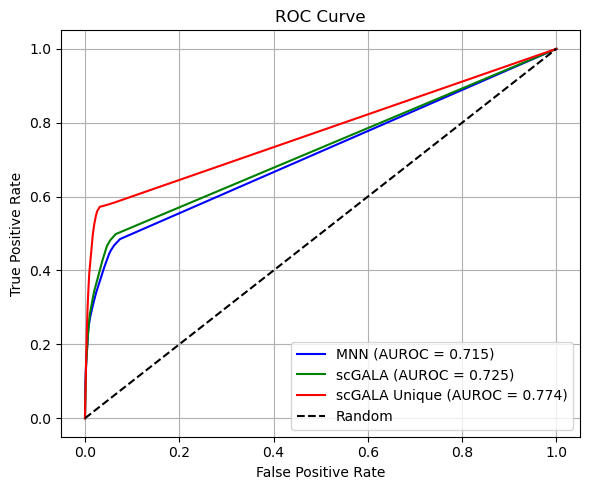

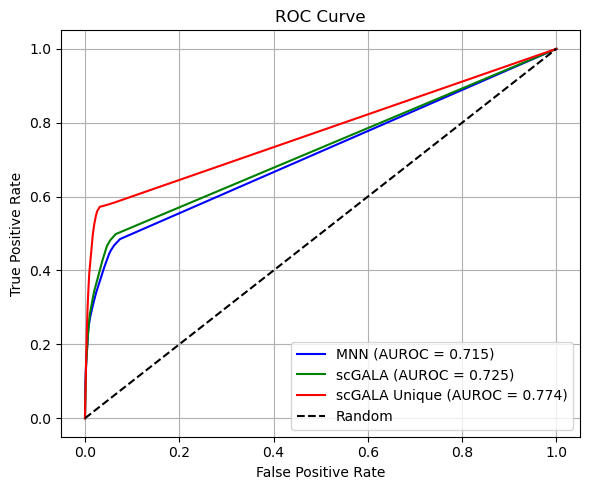

In [ ]:
fig = plot_roc(RNA_atac_mnn,RNA_adt_mnn,RNA_atac_scGALA,RNA_adt_scGALA,RNA_atac_only_scGALA,RNA_adt_only_scGALA,average='micro')
fig.savefig('./Results/figs/eval_roc_micro.pdf',dpi=300,bbox_inches='tight')
fig = plot_roc(RNA_atac_mnn,RNA_adt_mnn,RNA_atac_scGALA,RNA_adt_scGALA,RNA_atac_only_scGALA,RNA_adt_only_scGALA,average='macro')
fig.savefig('./Results/figs/eval_roc_macro.pdf',dpi=300,bbox_inches='tight')

## Step 6: Visualizing Cell Type-Specific Alignments with Heatmaps

To get a more detailed view of how each alignment method performs across different cell types, we'll generate heatmaps that show the distribution of alignments across cell types. These heatmaps will reveal whether certain cell types are aligned more accurately than others and help identify potential biases in the alignment methods.

The following function creates confusion matrices for each method, where rows represent cell types in the ATAC dataset and columns represent cell types in the ADT dataset. Higher values along the diagonal indicate better alignment performance.

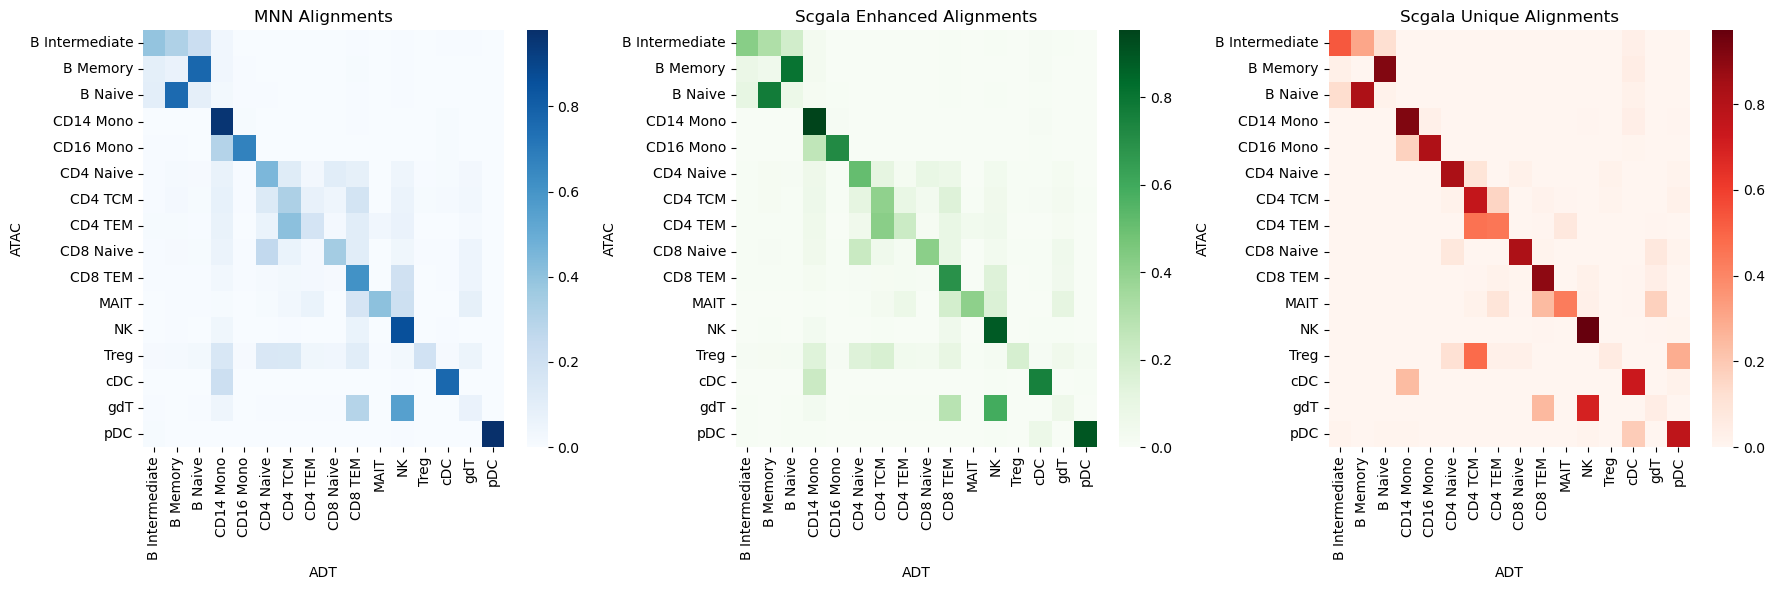

In [ ]:
import seaborn as sns

def plot_alignment_heatmap(adata_mnn1, adata_mnn2, adata_scGALA1, adata_scGALA2, adata_only_scGALA1, adata_only_scGALA2):
    # Get cell type labels
    categories = pd.Categorical(pd.concat([
        adata_mnn1.obs['celltype'], adata_mnn2.obs['celltype'],
        adata_scGALA1.obs['celltype'], adata_scGALA2.obs['celltype'],
        adata_only_scGALA1.obs['celltype'], adata_only_scGALA2.obs['celltype']
    ]).unique())
    num_classes = len(categories.categories)
    def get_labels(adata,categories):
        return pd.Categorical(
            adata.obs['celltype'], 
            categories=categories.categories
        )

    # Convert labels to categorical
    mnn1_labels = get_labels(adata_mnn1, categories)
    mnn2_labels = get_labels(adata_mnn2, categories)
    scGALA1_labels = get_labels(adata_scGALA1, categories)
    scGALA2_labels = get_labels(adata_scGALA2, categories)
    only_scGALA1_labels = get_labels(adata_only_scGALA1, categories)
    only_scGALA2_labels = get_labels(adata_only_scGALA2, categories)

    # Create confusion matrices
    mnn_confusion = pd.crosstab(mnn1_labels, mnn2_labels, normalize='index')
    scGALA_confusion = pd.crosstab(scGALA1_labels, scGALA2_labels, normalize='index')
    only_scGALA_confusion = pd.crosstab(only_scGALA1_labels, only_scGALA2_labels, normalize='index')

    # Plot heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sns.heatmap(mnn_confusion, ax=axes[0], cmap='Blues', annot=False, fmt='.2f')
    axes[0].set_title('MNN Alignments')
    axes[0].set_xlabel('ADT')
    axes[0].set_ylabel('ATAC')

    sns.heatmap(scGALA_confusion, ax=axes[1], cmap='Greens', annot=False, fmt='.2f')
    axes[1].set_title('Scgala Enhanced Alignments')
    axes[1].set_xlabel('ADT')
    axes[1].set_ylabel('ATAC')

    sns.heatmap(only_scGALA_confusion, ax=axes[2], cmap='Reds', annot=False, fmt='.2f')
    axes[2].set_title('Scgala Unique Alignments')
    axes[2].set_xlabel('ADT')
    axes[2].set_ylabel('ATAC')

    plt.tight_layout()
    return fig,mnn_confusion,scGALA_confusion,only_scGALA_confusion

# Generate and save heatmap
fig,mnn_confusion,scGALA_confusion,only_scGALA_confusion = plot_alignment_heatmap(RNA_atac_mnn, RNA_adt_mnn, RNA_atac_scGALA, RNA_adt_scGALA, RNA_atac_only_scGALA, RNA_adt_only_scGALA)
mnn_confusion.to_csv('./Results/figs/eval_alignment_confusion_matrix_mnn.csv')
scGALA_confusion.to_csv('./Results/figs/eval_alignment_confusion_matrix_scGALA.csv')
only_scGALA_confusion.to_csv('./Results/figs/eval_alignment_confusion_matrix_only_scGALA.csv')
fig.savefig('./Results/figs/eval_alignment_heatmap.pdf', dpi=300, bbox_inches='tight')


## Conclusion

In this tutorial, we demonstrated how scGALA can be used for multiplet-omics integration, specifically integrating RNA+ATAC and RNA+ADT datasets through their shared RNA modality. The key findings from our analysis:

1. **Traditional MNN** provides a baseline approach for cell alignment but may miss biologically relevant connections due to technical noise or batch effects.

2. **scGALA's unique alignments** discover additional biologically meaningful cell pairs that MNN misses, leveraging both local and global connectivity patterns in the data.

3. **Combined approach (scGALA+MNN)** yields the most comprehensive integration, preserving high alignment accuracy while increasing coverage.

4. **Visualizations** through ROC curves and heatmaps confirm that scGALA produces biologically meaningful alignments with high cell type specificity.

This integration capability represents a significant advancement, as it allows researchers to leverage existing doublet-omics datasets to gain insights that would otherwise require more complex and costly experimental designs. By creating a bridge between separately measured modalities, scGALA enables the construction of comprehensive molecular profiles that provide deeper insights into cellular heterogeneity and function.